# 多模型结果可视化

> 需要修改网络结果的路径

In [17]:
import os
import copy
import nibabel as nib
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap, BoundaryNorm
import tracemalloc

# 配置Jupyter友好显示

%matplotlib inline
# plt.ioff()  # 关闭交互模式避免重复绘图

In [18]:
def trans_from_wins_to_linux(path):
        path = path.replace('D:', '/mnt/d')
        path = path.replace('\\', '/')
        return path

## 模型配置

In [19]:

# 🏆 SOTA模型配置
SOTA_MODELS_CONFIG = {
    'DCLA_UNet_NoRes_250615': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\消融实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.88】DCLA_UNet_NoRes_250615_2025-06-17_lr0.0003_mlr1e-06_Tmax100_100_100\output\DCLA_UNet_NoRes_250615_20250623133812"),
    'UNet3D': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.862】UNet3D_2025-05-27_lr0.0003_mlr1e-06_Tmax100_100_100\checkpoints\UNet3D_20250605143708"),
    'AttUNet3D': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.86】AttUNet3D_2025-05-28_lr0.0003_mlr1e-06_Tmax100_100_100\output\AttUNet3D_20250605151326"),
    'UNETR': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.855】UNETR_2025-04-09_lr0.0001_mlr1e-06_Tmax100_100_100\output\UNETR_20250605152256"),
    'UNETR_PP': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.867】UNETR_PP_2025-05-29_lr0.0003_mlr1e-06_Tmax100_100_100\output\UNETR_PP_20250605153158"),
    'SegFormer3D': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.844】SegFormer3D_2025-05-30_lr0.0003_mlr1e-06_Tmax100_100_100\output\SegFormer3D_20250605155900"),
    'Mamba3d': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.816】Mamba3d_2025-05-15_lr0.0001_mlr1e-06_Tmax100_100_100\output\Mamba3d_20250605154047"),
    'MogaNet': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\对比实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.875】MogaNet_2025-05-30_lr0.0003_mlr1e-06_Tmax100_100_100\output\MogaNet_20250625101638"),
}
print(f'🏆 SOTA模型数量: {len(SOTA_MODELS_CONFIG)}')

# 🧪 消融实验模型配置
ABLATION_MODELS_CONFIG = {
    'DCLA_UNet_NoRes_250615': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\消融实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.88】DCLA_UNet_NoRes_250615_2025-06-17_lr0.0003_mlr1e-06_Tmax100_100_100\output\DCLA_UNet_NoRes_250615_20250623133812"),
    'SLK_UNet_250607': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\消融实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.877】SLK_UNet_250607_2025-06-07_lr0.0003_mlr1e-06_Tmax100_100_100\output\SLK_UNet_250607_20250610172542"),
    'MSF_UNet_250607': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\消融实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.879】MSF_UNet_250607_2025-06-08_lr0.0003_mlr1e-06_Tmax100_100_100\output\MSF_UNet_250607_20250610173527"),
    'SLK_MSF_UNet': trans_from_wins_to_linux(r"D:\results\DCLA_Unet_final\消融实验【lr0.0003_mlr1e-06_Tmax100_100_100】\【0.882】SLK_MSF_UNet_250607_2025-06-08_lr0.0003_mlr1e-06_Tmax100_100_100\output\SLK_MSF_UNet_250607_20250610174542")
}


DATA_DIR = 'D:\data\BraTS21_original_kaggle\BraTS2021_Training_Data'
IDS= ['00062', '01130', '01181', '01613']
MODALITIES = ['flair', 't1', 't1ce', 't2', 'seg']

🏆 SOTA模型数量: 8


## 颜色配置

In [20]:
# 创建颜色映射
COLOR_MAP = ListedColormap([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], name='custom_discrete', N=4)
BOUNDARIES = [0, 1, 2, 3, 4]
NORM = BoundaryNorm(BOUNDARIES, COLOR_MAP.N)


mp_conditions ={
    "all": lambda y: np.isin(y, [0]),
    "wt": lambda y: np.isin(y, [0]),
    "tc": lambda y: np.isin(y, [0,2]),
    "et": lambda y: np.isin(y, [0,1,2])
}

## 6. 🎛️ 交互式功能实现（修复版）

interactive(children=(Dropdown(description='Axis', options=('Axial (0)', 'Sagittal (1)', 'Coronal (2)'), value…

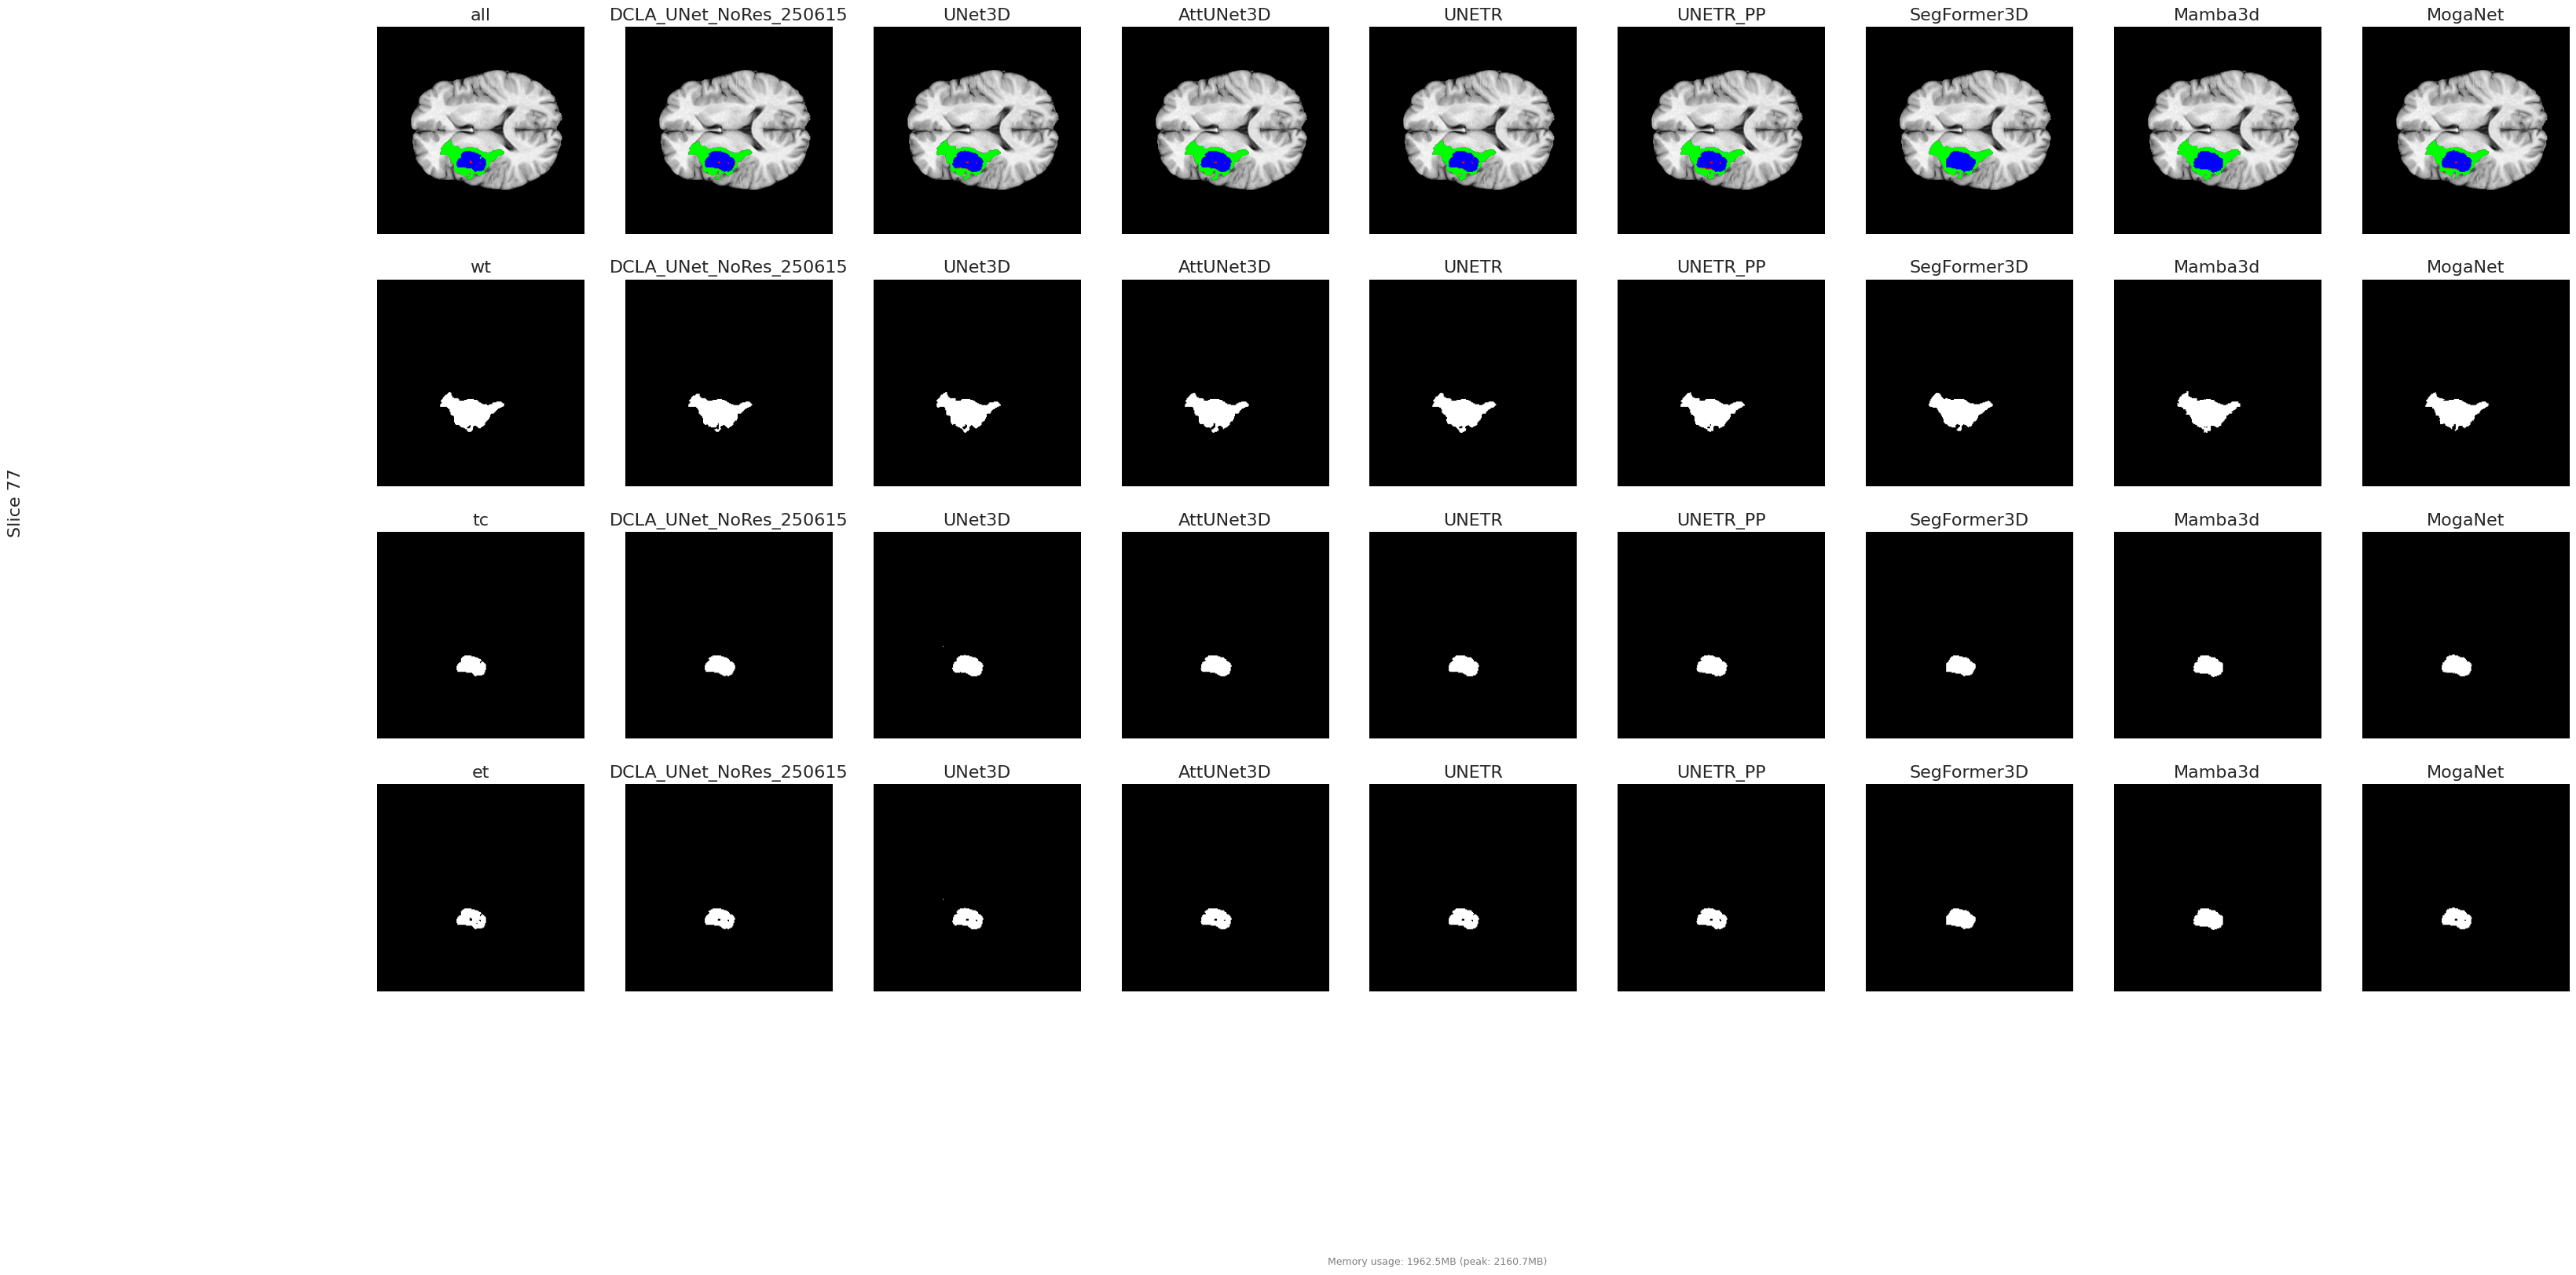

In [21]:
class MedicalVisualizer:
    def __init__(self, data_dir, base_model_cfg, ids, modals):
        """
        初始化可视化器
        :param original_data: 包含原始图像和GT的字典  {'flair':..., 'gt':...}
        :param pred_data: 包含预测结果的字典 {model_name: 3D_array...}
        """
        self.data_dir = data_dir
        self.base_model_cfg = base_model_cfg
        self.ids = ids
        self.modals = modals
        self.original_paths_dict = self._get_original_paths()
        self.all_pred_paths_dict = self._get_pred_paths_cfg()
        self.fig = None
        tracemalloc.start()  # 启动内存监控

    def _get_original_paths(self):
        """获所有患者的正常样本数据的路径"""
        original_paths_dict = {}
        for id in self.ids:
            id_paths_dict = {}
            for modal in self.modals:
                path = trans_from_wins_to_linux(os.path.join(self.data_dir, f"BraTS2021_{id}/BraTS2021_{id}_{modal}.nii.gz"))
                id_paths_dict[modal] = path
                # path = None
            original_paths_dict[id] = id_paths_dict
            # id_paths_dict.clear()
        return original_paths_dict
    
    
    def _get_pred_paths_cfg(self):
        """获取指定患者ID的所有网络预测结果"""
        all_pred_paths_dict = {}
        for id in self.ids:
            file_path = f"BraTS2021_{id}/BraTS2021_{id}_pred.nii.gz"
            new_cfg = copy.deepcopy(self.base_model_cfg)
            for model_name in new_cfg:
                new_cfg[model_name] = trans_from_wins_to_linux(os.path.join(new_cfg[model_name], file_path))
            all_pred_paths_dict[id] = new_cfg
        return all_pred_paths_dict

    def _get_data(self, patient_id):
        """获取指定患者ID的数据"""
        
        # 获取地址
        id_orginal_paths_dict = self.original_paths_dict[patient_id]
        id_pred_paths_dict = self.all_pred_paths_dict[patient_id]
        
        # 获取数据
        original_data = {}
        for modal, path in id_orginal_paths_dict.items():
            original_data[modal] = nib.load(path).get_fdata().transpose((2, 0, 1))
            
        pred_data = {}
        for model_name, path in id_pred_paths_dict.items():
            pred_data[model_name] = nib.load(path).get_fdata().transpose((2, 0, 1))
        return original_data, pred_data
        
    def _get_slices(self, axis, slice_idx, patient_id):
        """获取指定轴和切片的图像数据"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        data = {
            'nii': id_original_data['t1'],
            'gt': id_original_data['seg'],
            'preds': id_pred_data
        }
        slicer = {
            0: lambda x: x[slice_idx],
            1: lambda x: x[:, slice_idx],
            2: lambda x: x[:, :, slice_idx]
        }
        
        return {k: slicer[axis](v) if k != 'preds' else 
                {m: slicer[axis](d) for m, d in v.items()} 
                for k, v in data.items()}

    def _plot_sub_rigons(self, ax, slice_data, slice_mask, mp_condition, color_map, norm, alpha=1, title_txt=None, show_original=False):
        
        """绘制子区域分割图"""
        
        if show_original:
            ax.imshow(slice_data, cmap='gray')
            masked_slice = np.ma.masked_where(mp_condition, slice_mask)
            # ax.set_facecolor('black')
            ax.imshow(masked_slice, cmap=color_map, norm=norm, alpha=alpha)
            # 设置被掩码的区域为黑色（通过设置cmap的bad值）
            # color_map.set_bad(color='black')
            ax.set_title(title_txt)
            ax.axis('off')
        else:
            # 创建全1数组替代slice_mask
            ones_array = np.ones_like(slice_mask)
            # ax.imshow(slice_data, cmap='gray')
            masked_slice = np.ma.masked_where(~mp_condition, ones_array)
            ax.set_facecolor('black')
            ax.imshow(masked_slice, cmap='bone', norm=norm, alpha=alpha)
            # 设置被掩码的区域为黑色（通过设置cmap的bad值）
            # color_map.set_bad(color='black')
            ax.set_title(title_txt)
            ax.axis('off')
        

    def _plot_slice(self, axis, slice_idx, patient_id, save_flag=False, save_dir=None):
        """绘制单个切片"""
        data = self._get_slices(axis, slice_idx, patient_id)
        
        # 动态计算布局
        n_models = len(data['preds'])
        total_cols = n_models+1
        total_rows = 4
        figsize = (4*total_cols, 4*total_rows) 
        
        if self.fig is None:
            self.fig, axs = plt.subplots(total_rows, total_cols, figsize=figsize)
        else:
            self.fig.clear()
            axs = self.fig.subplots(total_rows, total_cols)
        
        
        # gt_condition = 
        gt_conditions = {
            k: v(data['gt'])
            for k, v in mp_conditions.items()
        }
        # 绘制第（i，j）的图；i为子区域，j为不同的模型
        for i, (mod, mp_condition) in enumerate(gt_conditions.items()):
            if i == 0: # 绘制整体效果
                # 绘制gt
                self._plot_sub_rigons(axs[i][0], data['nii'], data['gt'], mp_condition=mp_condition, color_map=COLOR_MAP, norm=NORM, title_txt=mod, show_original=True )
                # 绘制各模型预测
                for j, (model_name, pred) in enumerate(data['preds'].items(), 1):
                    self._plot_sub_rigons(axs[i][j], data['nii'], pred, mp_condition=mp_conditions[mod](pred), color_map=COLOR_MAP, norm=NORM, title_txt=model_name, show_original=True)
            else:
                # 绘制gt
                self._plot_sub_rigons(axs[i][0], data['nii'], data['gt'], mp_condition=mp_condition, color_map=COLOR_MAP, norm=NORM, title_txt=mod)
                # 绘制各模型预测
                for j, (model_name, pred) in enumerate(data['preds'].items(), 1):
                    self._plot_sub_rigons(axs[i][j], data['nii'], pred, mp_condition=mp_conditions[mod](pred), color_map=COLOR_MAP, norm=NORM, title_txt=model_name)
            
        # 显示内存使用情况
        current, peak = tracemalloc.get_traced_memory()
        self.fig.suptitle(f"Memory usage: {current/1e6:.1f}MB (peak: {peak/1e6:.1f}MB)",
                        y=-0.1, fontsize=9, color='gray')
        self.fig.text(0, 0.5, f'Slice {slice_idx}', va='center', ha='right', rotation=90, fontsize=16)
        
        if save_flag and save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            datetime_str = datetime.now().strftime('%Y%m%d%H%M%S')
            self.fig.savefig(os.path.join(save_dir, f'{patient_id}_{slice_idx}_{datetime_str}.png'))
            print(f'saved {patient_id}_{slice_idx}_{model_name}.png under {save_dir}')
            
        clear_output(wait=True)  # 清除之前的输出
        display(self.fig)        # 异步显示

    def interactive_view(self, patient_id, save_flag=False, save_dir=None):
        """生成交互式控件"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        self.sample_data = id_original_data['t1']
        max_slices = {
            0: self.sample_data.shape[0]-1,
            1: self.sample_data.shape[1]-1,
            2: self.sample_data.shape[2]-1
        }

        @interact(
            Axis=['Axial (0)', 'Sagittal (1)', 'Coronal (2)'],
            Slice=IntSlider(min=0, max=max_slices[0], value=max_slices[0]//2),
            # Patients=self.patient_ids 
        )
        def slice_explorer(Axis, Slice):
            axis = int(Axis.split('(')[1][0])
            self._plot_slice(axis, Slice, patient_id, save_flag=save_flag, save_dir=save_dir)
            

    def show_volume(self, patient_id, axis=0, step=5):
        """快速浏览整个体积"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        
        max_slice = self.sample_data.shape[axis]-1
        for s in range(0, max_slice+1, step):
            self._plot_slice(axis, s, patient_id)
            plt.pause(0.1)  # 添加短暂延迟保证显示
            
    def close(self):
        """释放资源"""
        if self.fig is not None:
            plt.close(self.fig)
        tracemalloc.stop()


vis = MedicalVisualizer(DATA_DIR, SOTA_MODELS_CONFIG, IDS, MODALITIES)

save_path = f"/mnt/d/results/compared_slices"
vis.interactive_view('01613', False, save_path)  # 显示交互控件    IDS= ['00062', '01130', '01181', '01613']


In [22]:
# vis.interactive_view('01130', False, save_path)  # 显示交互控件

In [23]:
# vis = MedicalVisualizer(DATA_DIR, ABLUTIONS_MODELS_CONFIG, IDS, MODALITIES)
# save_path = f"/mnt/d/results/compared_slices"
# vis.interactive_view('01181', False, save_path)  # 显示交互控件

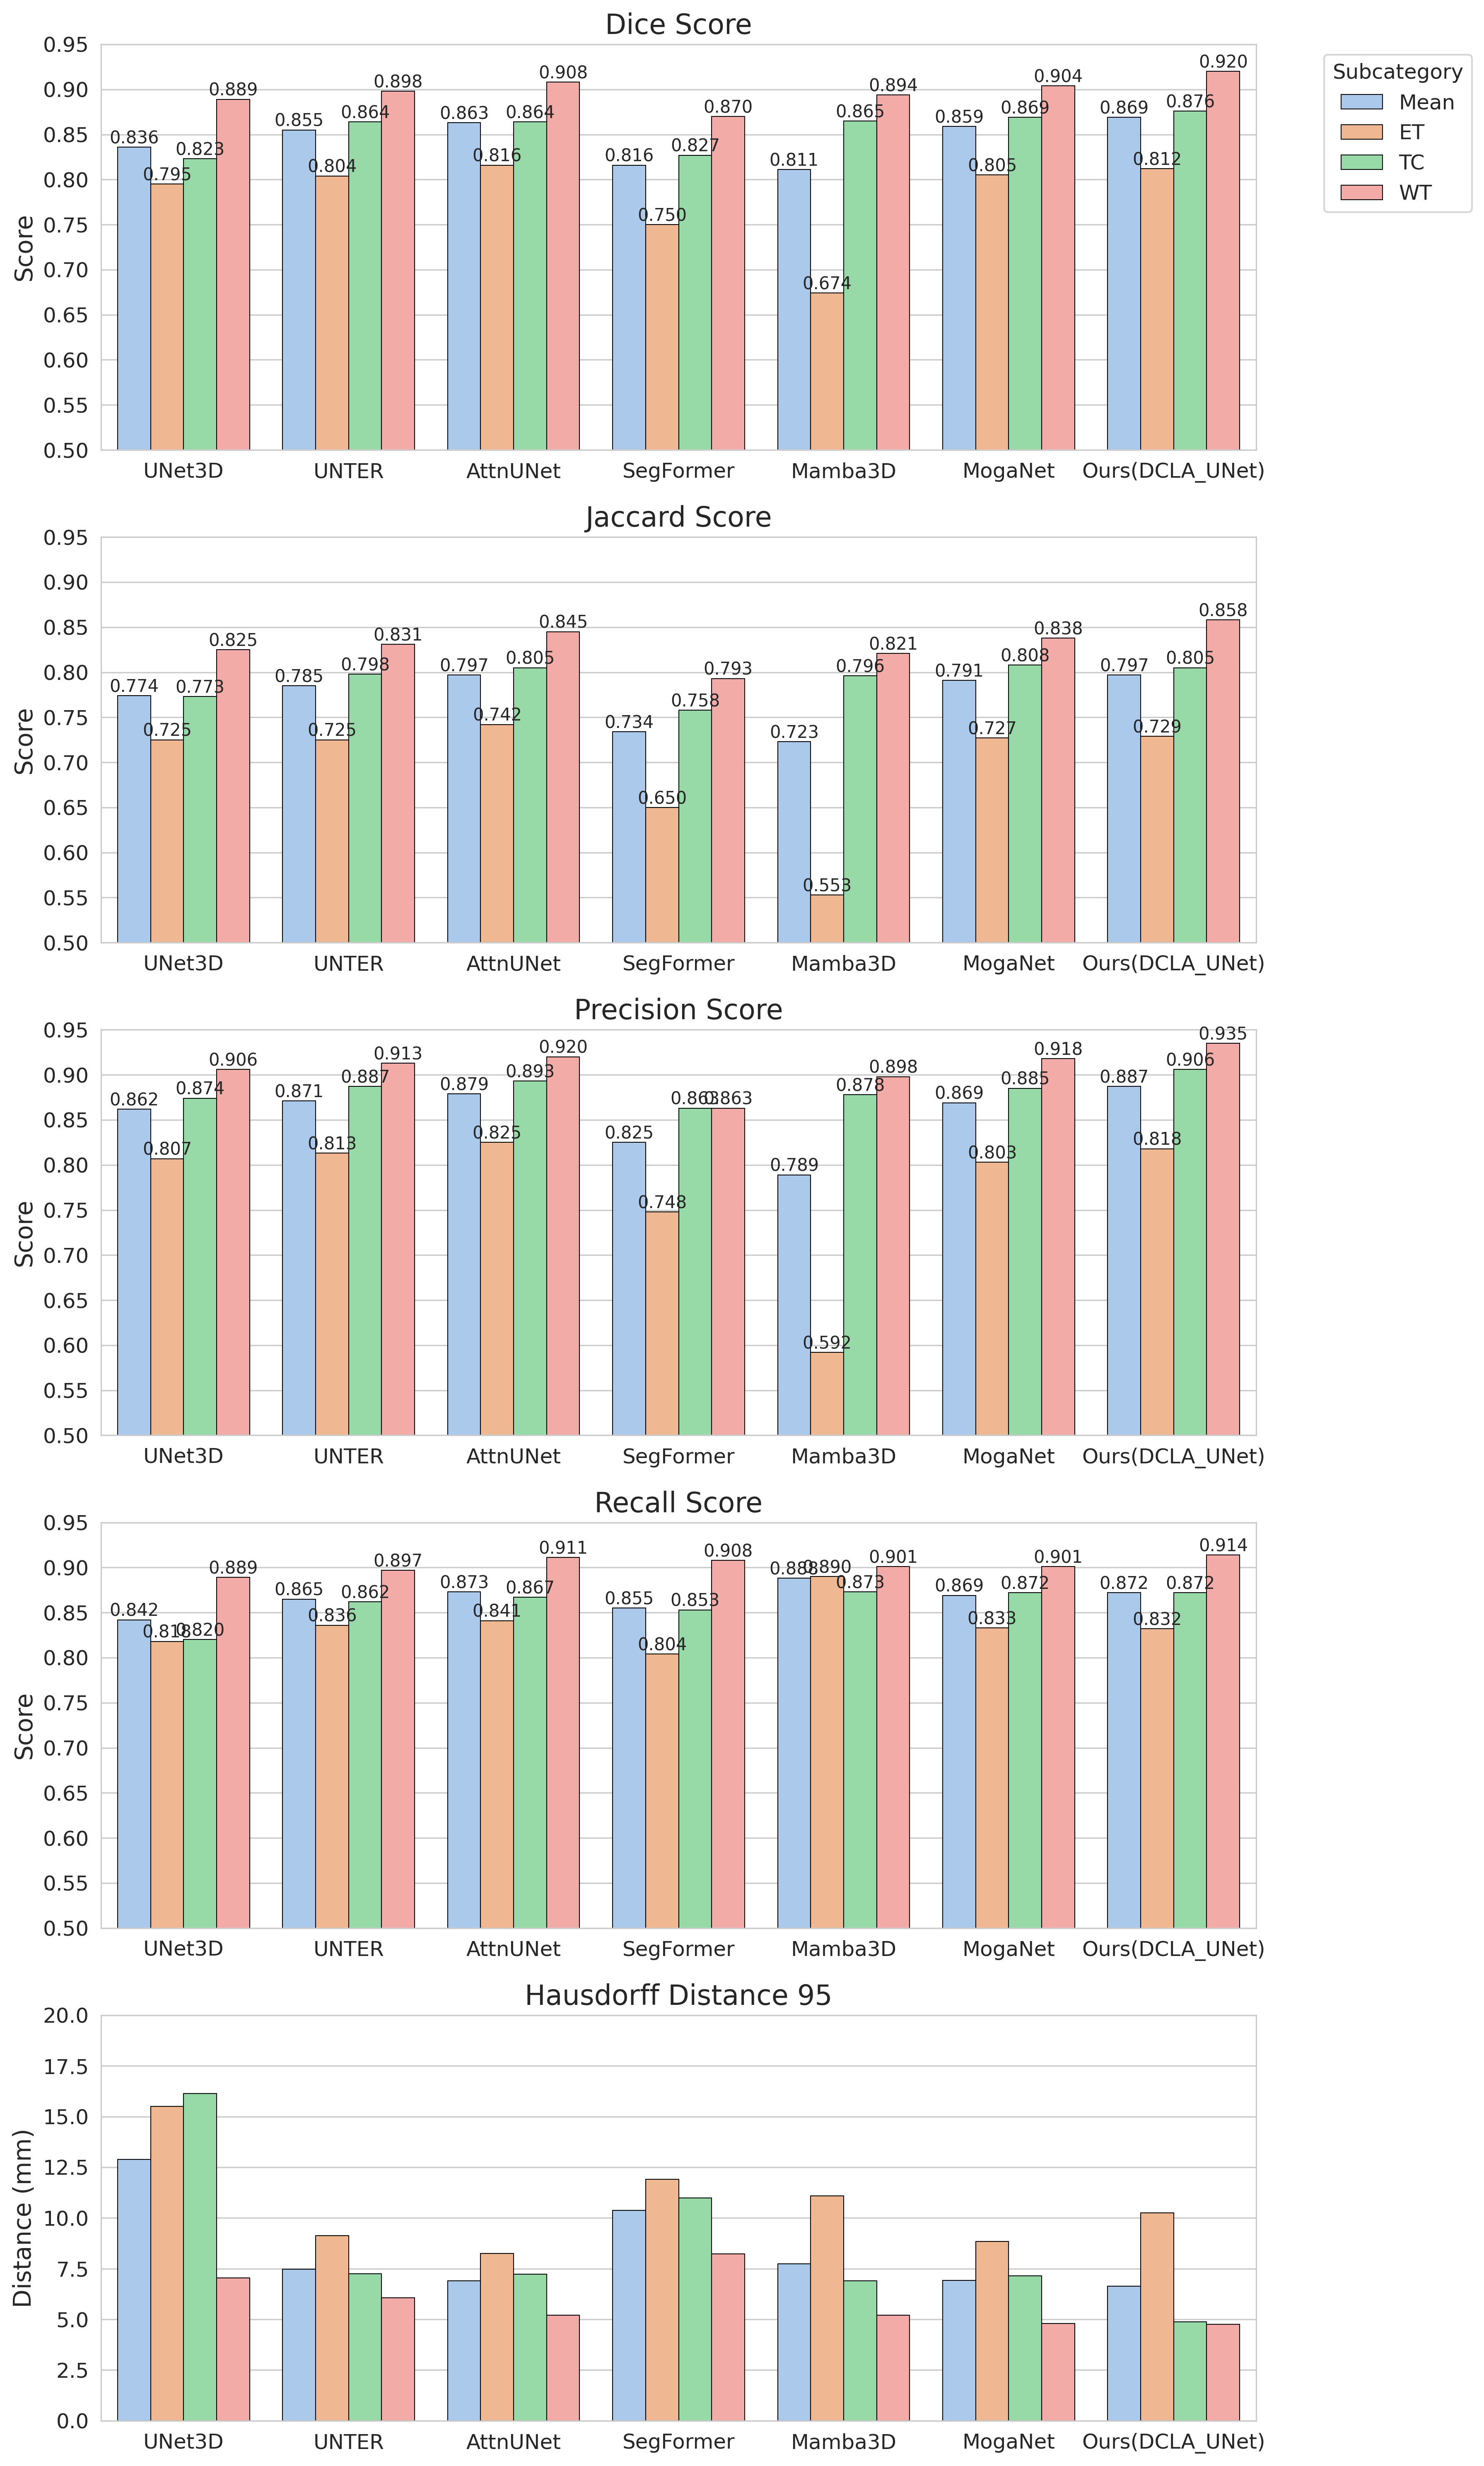

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 设置绘图样式
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})
sns.set_style("whitegrid")
# 创建数据框
data = [
    ["UNet3D", 0.836,0.795,0.823,0.889, 0.774,0.725,0.773,0.825, 0.862,0.807,0.874,0.906, 0.842,0.818,0.82,0.889, 12.888,15.492,16.134,7.038],
    ["UNTER", 0.855,0.804,0.864,0.898, 0.785,0.725,0.798,0.831, 0.871,0.813,0.887,0.913, 0.865,0.836,0.862,0.897, 7.483,9.128,7.257,6.065],
    ["AttnUNet", 0.863,0.816,0.864,0.908, 0.797,0.742,0.805,0.845, 0.879,0.825,0.893,0.92, 0.873,0.841,0.867,0.911, 6.895,8.252,7.223,5.209],
    ["SegFormer", 0.816,0.75,0.827,0.87, 0.734,0.65,0.758,0.793, 0.825,0.748,0.863,0.863, 0.855,0.804,0.853,0.908, 10.372,11.904,10.984,8.229],
    ["Mamba3D", 0.811,0.674,0.865,0.894, 0.723,0.553,0.796,0.821, 0.789,0.592,0.878,0.898, 0.888,0.89,0.873,0.901, 7.731,11.096,6.902,5.196],
    ["MogaNet", 0.859,0.805,0.869,0.904, 0.791,0.727,0.808,0.838, 0.869,0.803,0.885,0.918, 0.869,0.833,0.872,0.901, 6.927,8.834,7.151,4.795],
    ["Ours(DCLA_UNet)", 0.869,0.812,0.876,0.92, 0.797,0.729,0.805,0.858, 0.887,0.818,0.906,0.935, 0.872,0.832,0.872,0.914, 6.632,10.257,4.883,4.755]
]
columns = [
    "Models",
    *[f"Dice_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Jaccard_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Precision_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Recall_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"HD95_{m}" for m in ["Mean","ET","TC","WT"]]
]
df = pd.DataFrame(data, columns=columns)
df = df.melt(id_vars="Models", var_name="Metric", value_name="Value")
df[["Metric", "Subcategory"]] = df["Metric"].str.split("_", expand=True)
# 定义绘图参数
metrics = ["Dice", "Jaccard", "Precision", "Recall", "HD95"]
palette = sns.color_palette("pastel", n_colors=4)
model_order = df.Models.unique()
# 创建子图
fig, axs = plt.subplots(5, 1, figsize=(12, 20), dpi=300)
plt.subplots_adjust(hspace=0.4)
# 为每个指标绘制图表
for idx, metric in enumerate(metrics):
    ax = axs[idx]
    mask = df.Metric == metric
    data = df[mask]
    sns.barplot(data=data, x="Models", y="Value", hue="Subcategory",
                palette=palette, ax=ax, order=model_order,
                edgecolor="black", linewidth=0.5)
    # 设置装饰参数
    ax.set_title(f"{metric} Score" if metric != "HD95" else "Hausdorff Distance 95")
    ax.set_xlabel("")
    ax.set_ylabel("Score" if metric != "HD95" else "Distance (mm)")
    ax.set_ylim((0.5, 0.95) if metric != "HD95" else (0, 20))
    # 添加数值标签
    if metric != "HD95":
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.3f}", 
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=10)
    # 调整图例
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Subcategory", 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()
# 调整布局并保存
plt.tight_layout()
plt.savefig("model_comparison.png", bbox_inches='tight', dpi=300)
plt.show()
